<a href="https://colab.research.google.com/github/ohvictor/ASSD-2020-G4/blob/master/PI_TP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio 1

In [ ]:
s = 1.5   #mm
a = s*s   #mm^2
d = 15e4  #u/mm^2
conos = a*d #u
cono = 1/d  #mm^2
lado_cono = np.sqrt(cono)

In [ ]:
size_min_retina = lado_cono
dist_retina = 17  #mm
dist_lcd = 300  #mm
size_min_lcd = size_min_retina/dist_retina*dist_lcd
print("{:e}".format(size_min_lcd) + " mm")

4.556451e-02 mm


# Ejercicio 2

In [ ]:
f = 35    #mm
area = 10*10 #mm^2
res = 1e6 #pix
dist = 1000  #mm

In [ ]:
size_pix = area/res #mm2
side_pix = np.sqrt(size_pix)  #mm
size_img = size_pix/f*dist    #mm
print("{:e}".format(size_img) + " mm")

2.857143e-03 mm


#Ejercicio 3

Samsung Galaxy S9+:

https://www.samsung.com/sg/support/mobile-devices/everything-you-need-to-know-about-your-samsung-galaxy-s9-and-s9-plus-camera/
- Resolution: 12 Mpi
- Pixel size: 14 um
- Sensor size: 1/2.55''


In [ ]:
dist3 = 500 #mm


# Ejercicio 4

In [ ]:
import numpy as np
from PIL import Image, ImageShow

def repeat(img_data, size_new):
  size_old = np.array(img_data.shape)
  k_row, k_col =  size_new/size_old
  #ii = (np.floor((np.arange(size_new[0]))*k_row)).astype(int)
  #jj = (np.floor((np.arange(size_new[1]))*k_col)).astype(int)
  
  #img_new = img_data[ii,:][:,jj]
  return np.repeat(np.repeat(img_data,k_col, axis=1),k_row, axis=0)

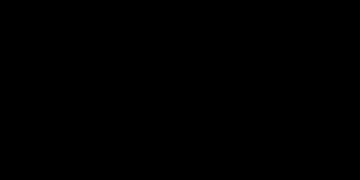

In [ ]:
from PIL import Image, ImageShow
img_size = (360, 180)
im = Image.new("L",img_size)
display(im)

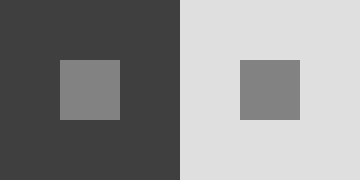

In [ ]:
b = 63
g = 130
w = 223
new_size = [180, 360]
data1 = np.array([[b,b,b,w,w,w],[b,g,b,w,g,w],[b,b,b,w,w,w]],np.uint8)
data3 = repeat(data1, new_size)
data3.shape
display(Image.fromarray(data3))

# Ejercicio 5
Se buscó decimar y re-escalar la imagen del mono
1. En una sección de 4x4, el píxel (2,2)
2. En una sección de 4x4, el píxel (1,1)
3. En una sección de 4x4, el promedio de todos los píxeles

Luego, se implementó las funciones de interpolación bilineal y bicúbica, y se las comparó con el resultado de las funciones de escalamiento de la librería PIL.

En el caso de la interpolación bilineal se pudo obtener resultados similares.
Sin embargo, en la interpolación bicúbica no se puede decir lo mismo.

In [2]:
def decimate(img_data, kernel_size, pixel_pick):
  return img_data[pixel_pick[0]::kernel_size[0],pixel_pick[1]::kernel_size[1]]

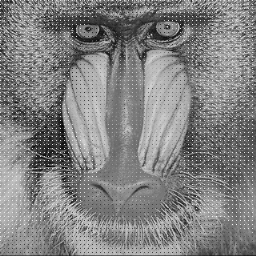

array([[227,  57,  87, ...,  90, 116, 128],
       [114,  83,  71, ..., 117,  86,  64],
       [ 77, 112,  78, ..., 102,  66, 139],
       ...,
       [102, 135, 143, ...,  95,  96,  88],
       [138, 140, 124, ...,  90,  87,  83],
       [ 82,  68,  57, ...,  41,  41,  37]], dtype=uint8)

In [4]:
import numpy as np
from PIL import Image, ImageShow
mono = Image.open("mono.bmp")
mono.size
mono_data = np.asarray(mono)
display(mono)
display(mono_data)

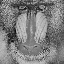

In [5]:
mono_22 = decimate(mono_data,[4,4],[2,2])
display(Image.fromarray(mono_22))

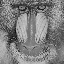

In [6]:
mono_11 = decimate(mono_data,[4,4],[1,1])
display(Image.fromarray(mono_11))

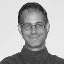

In [7]:
mono_00 = decimate(mono_data,[4,4],[0,0])
display(Image.fromarray(mono_00))

In [95]:
def decimate_mean(img_data, kernel_size):
  h,w = img_data.shape
  kernel_h, kernel_w = kernel_size
  ans = np.array([], np.uint8)
  for i in range(0,h,kernel_h):
    for j in range(0,w,kernel_w):
      calc = np.uint8(img_data[i:i+kernel_h,j:j+kernel_w].mean())
      ans = np.append(ans,calc)
  
  return ans.reshape(int(h/kernel_h),int(w/kernel_w))

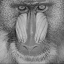

In [96]:
mono_mean = decimate_mean(mono_data, [4,4])
display(Image.fromarray(mono_mean))

# Interpolación

In [9]:
import numpy as np
from PIL import Image, ImageShow

def nearest_neighbor(img, size_new):
  size_old = np.array(img.size)
  k_row, k_col =  size_old / size_new
  ii = (np.ceil((np.arange(size_new[0])+1)*k_row)-1).astype(int)
  jj = (np.ceil((np.arange(size_new[1])+1)*k_col)-1).astype(int)

  img_new = np.asarray(img)[:,ii][jj,:]
  return img_new

In [21]:
def formula_linear(x0, y0, x1, y1, x):
  return y0*(x1-x)/(x1-x0)+y1*(x-x0)/(x1-x0)

In [28]:
def interpolation_linear(a, size):
  scale = a.size/size
  retval = np.zeros(size)  # Arreglo a rellenar
  pad = np.append(a[:],a[-1])
  for i,f in enumerate(retval):
    x = i*scale
    x1 = int(np.floor(x))
    x2 = int(np.ceil(x))
    y1, y2 = pad[x1], pad[x2]
    if(x1 == x2):
      retval[i] = y1
    else:
      retval[i] = formula_linear(x1,y1,x2,y2,x)
  return retval


In [90]:
def interpolation_bilinear(img_data, size):
  old_size = np.array(img_data.shape)
  k_row, k_col = old_size/size

  img_int = np.array([])
  for row in img_data:
    new_row = interpolation_linear(row, size[1])
    img_int = np.append(img_int, new_row)

  img_int = img_int.flatten()
  img_int = img_int.reshape((old_size[0], size[1]))
  img_int = img_int.transpose()

  img_fin = np.array([])
  for row in img_int:
    new_row = interpolation_linear(row, size[0])
    img_fin = np.append(img_fin, new_row)

  img_fin = img_fin.flatten()
  img_fin = img_fin.reshape(tuple(size))
  img_fin = img_fin.transpose()

  return img_fin.astype(np.uint8)

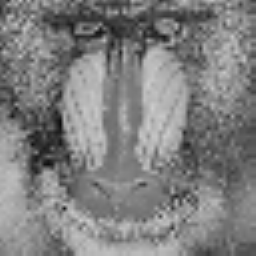

In [91]:
mono_22_bil = interpolation_bilinear(mono_22, [256,256])
display(Image.fromarray(mono_22_bil))

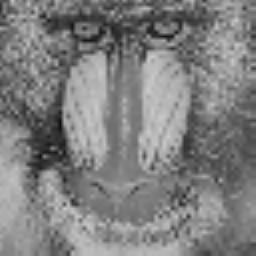

In [92]:
mono_11_bil = interpolation_bilinear(mono_11, [256,256])
display(Image.fromarray(mono_11_bil))

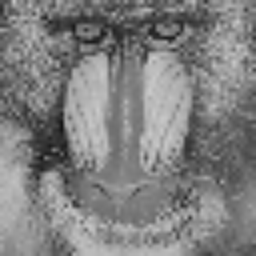

In [93]:
image_11 = Image.fromarray(mono_11)
image_11 = image_11.resize((256,256), resample=Image.BILINEAR)
display(image_11)

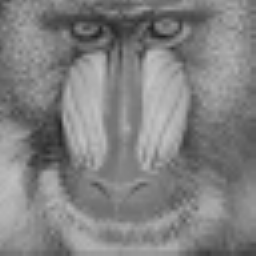

In [97]:
mono_mean_bil = interpolation_bilinear(mono_mean, [256,256])
display(Image.fromarray(mono_mean_bil))

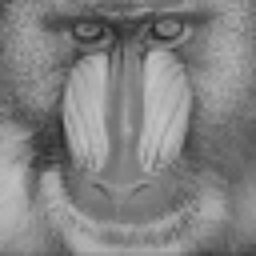

In [98]:
image_mean = Image.fromarray(mono_mean)
image_mean = image_mean.resize((256,256), resample=Image.BILINEAR)
display(image_mean)

In [139]:
def formula_cubic(p, x):
  """ Para x entre 0 y 1, se puede interpolar los valores en x con los valores pi
  Input:
  p - arreglo de valores [p0,p1,p2,p3]
  x - coordenada x
  Output:
  Valor interpolado en x
  """
  p0,p1,p2,p3 = p
  x3,x2 = x**3, x**2
  return (-0.5*p0+1.5*p1-1.5*p2+0.5*p3)*x3+(p0-2.5*p1+2*p2-0.5*p3)*x2+(-0.5*p0+0.5*p2)*x+p1

In [136]:
def interpolation_cubic(a, size):
  scale = a.size/size
  retval = np.zeros(size)

  a = np.append(a[0],a)
  a = np.append(a,a[-1])
  a = np.append(a,a[-1])

  for i,f in enumerate(retval):
    x = i*scale+1
    x0 = int(np.floor(x))-1
    x1 = int(np.floor(x))
    x2 = int(np.ceil(x))
    x3 = int(np.ceil(x)) +1

    p = [a[x0], a[x1], a[x2], a[x3]]

    if (x1 == x2):
      retval[i] = p[1]
    else:
      retval[i] = formula_cubic(p,x-np.floor(x))

  return retval

In [122]:
def interpolation_bicubic(img_data, size):
  old_size = np.array(img_data.shape)
  k_row, k_col = old_size/size

  img_int = np.array([])
  for row in img_data:
    new_row = interpolation_cubic(row, size[1])
    img_int = np.append(img_int, new_row)

  img_int = img_int.flatten()
  img_int = img_int.reshape((old_size[0], size[1]))
  img_int = img_int.transpose()

  img_fin = np.array([])
  for row in img_int:
    new_row = interpolation_cubic(row, size[0])
    img_fin = np.append(img_fin, new_row)

  img_fin = img_fin.flatten()
  img_fin = img_fin.reshape(tuple(size))
  img_fin = img_fin.transpose()

  return img_fin.astype(np.uint8)

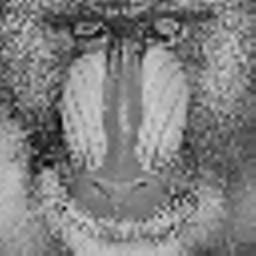

In [137]:
mono_22_bic = interpolation_bicubic(mono_22, [256,256])
display(Image.fromarray(mono_22_bic))

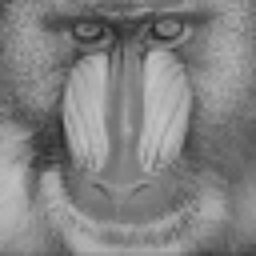

In [130]:
image_22_c = Image.fromarray(mono_22)
image_22_c = image_mean.resize((256,256), resample=Image.BICUBIC)
display(image_22_c)

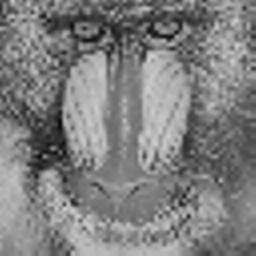

In [128]:
mono_11_bic = interpolation_bicubic(mono_11, [256,256])
display(Image.fromarray(mono_11_bic))

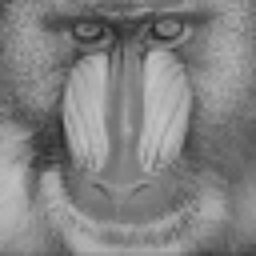

In [131]:
image_11_c = Image.fromarray(mono_11)
image_11_c = image_mean.resize((256,256), resample=Image.BICUBIC)
display(image_11_c)

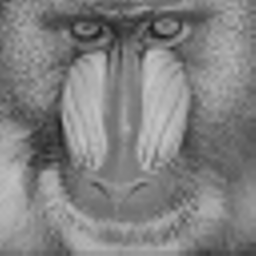

In [129]:
mono_mean_bic = interpolation_bicubic(mono_mean, [256,256])
display(Image.fromarray(mono_mean_bic))

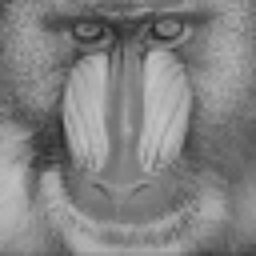

In [132]:
image_mean_c = Image.fromarray(mono_mean)
image_mean_c = image_mean.resize((256,256), resample=Image.BICUBIC)
display(image_mean_c)

#FFT2

Se graficó la FFT de la imagen original, y se observó que existen picos de amplitud de ciertas frecuencias, formando un patrón de grilla.

Esto se puede deber a la grilla de puntos blancos dibujada sobre el mono, de manera tal que hay una frecuencia horizontal, vertical y diagonal fuerte, además de una componente de continua también fuerte.

In [149]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageShow
from matplotlib.colors import LogNorm

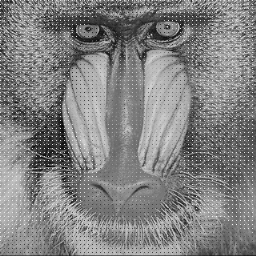

In [147]:
mono = Image.open("mono.bmp")
mono.size
mono_data = np.asarray(mono)
display(mono)

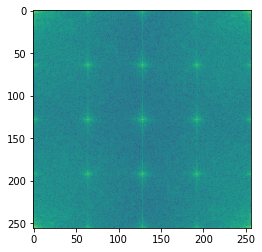

In [154]:
mono_fft = np.fft.fft2(mono_data)
abs = np.abs(mono_fft)
plt.imshow(abs, norm=LogNorm(vmin=5))